#### Load Modules

In [1]:
import math
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import sys

import scipy.stats as stats

sys.path.append('/Users/Lampe/PyScripts/CS_Research')
import ResearchFunc as rf
%matplotlib inline

#### Load Test Data

In [28]:
fname = "90-04_PFO_29psi.csv"
data = rf.minimeter_import(fname)

time_idx = 1
pdiff_idx = 2
p_idx = 3
T_conf_idx = 4
T_us_idx = 5
T_ds_idx = 6

In [29]:
def runningMean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

#### plot all data

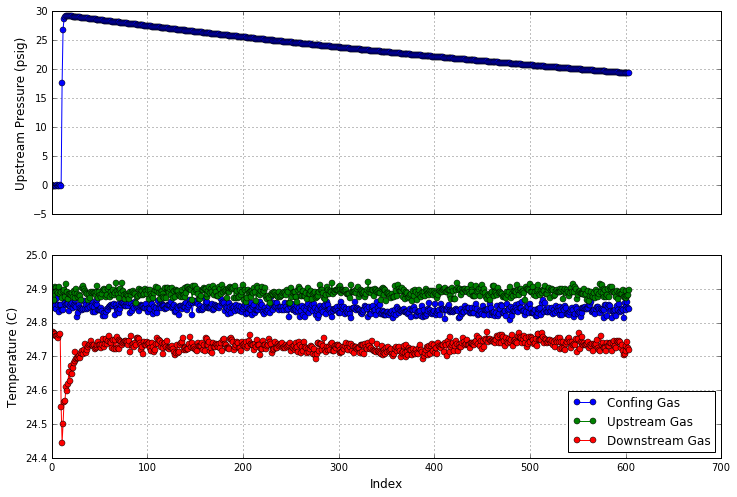

In [30]:
rf.plot_mmdat(data, splice=0, time_idx = 1, pdiff_idx = 2, p_idx = 3, T_conf_idx = 4, T_us_idx = 5, T_ds_idx = 6)

#### Identify data to analyze

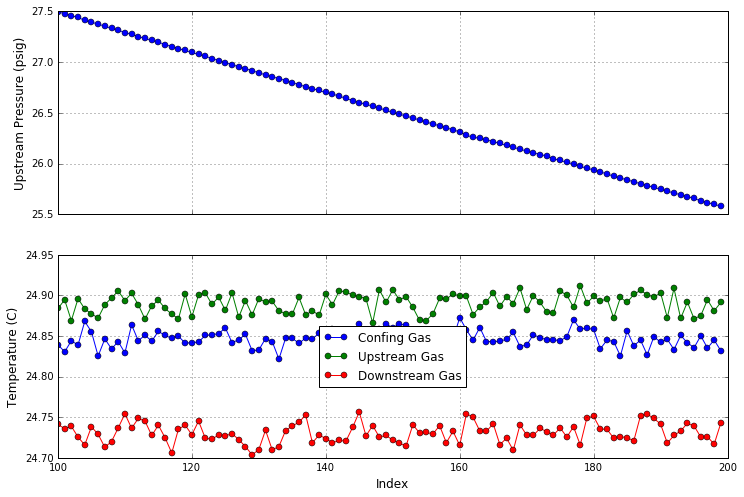

In [31]:
idx_min=100
idx_max=200
rf.plot_mmdat(data, 1, idx_min, idx_max)

#### Define the columns where data are located

In [32]:
time = data[idx_min:idx_max, time_idx]
pdiff_psi = data[idx_min:idx_max, pdiff_idx]
p_psi = data[idx_min:idx_max, p_idx]
T_conf = data[idx_min:idx_max, T_conf_idx]
T_us = data[idx_min:idx_max, T_us_idx]
T_ds = data[idx_min:idx_max, T_ds_idx]

#### Define Reference Conditions
Use NIST values for standard temperature and pressure

Ref: Wright, Johnson, and Moldover, 2003, Design and Uncertainty Analysis for a PVTt Gas Flow Standard, Journal of Research of the National Institute of Standards and Technology, Volume 108, Number 1, January-February 2003, 27 pgs.

In [33]:
Tstd = 20 + 273.15 # K
Pstd = 101325 # Pa
R = 8314.0 #gas const (m3-Pa)/(K-kmol)
g = 9.81 # gravitational acceleration (m/s2)

#### Define Sample Dimensions

In [34]:
Patm_psi = 12.2 # ambient absolute pressure, psia
L_cm = 8.91 # length of sample [cm]
d1_cm = 7.35 # diameter of sample [cm]
d2_cm = 8.08 # diameter of sample [cm]

In [35]:
Patm_pa = Patm_psi*(101325./14.6959)

#### Minimeter Volume

In [36]:
Vres = 428.9 * (1./100.**3) # reservoir volume (m3)
Vus = 39.78 * (1./100.**3)# upstream volume excluding reservoir (m3)
Vt = Vus + Vres # total minimiter volume during pressure falloff test

In [37]:
T_c = (T_us + T_ds)/2. # average temperature at all times (C)

Convert values to SI unis

In [38]:
T = T_c + 273.15 # abs temp (K)
L = L_cm/100 # length (m)
D = (d1_cm + d2_cm)/(2*100) # diam (m)
A = (np.pi*D**2)/4.0 # area of sample orth to flow direction (m2)
M = 28.0134 # molecular weight of nitrogen (kg/kg-mole)
Patm_pa = Patm_psi*(101.325e3 / 14.6959) # downstream absolute gas pressure (Pa)
p_pa = p_psi*(101.325e3 / 14.6959) # upstream gauge gas pressure (Pa)
P_pa = (p_psi + Patm_psi)*(101.325e3 / 14.6959) # absolute upstream gas pressure (Pa)
P_psi = P_pa*(14.6959/101.325e3) #absolute upstream gas pressure (psi)

Calculate mass flow rate through the sample

In [39]:
rho1 = rf.rho_n2(T,P_pa)# upstream gas density (kg/m3)
m1 = rho1*Vt #upstream gas mas
m1_dot = -Vt*np.diff(rho1,1)/np.diff(time,1) # mass flow rate into sample (kg/sec)

Calculate volumetric flow rate into sample and other metrics

In [40]:
rho1_avg = np.zeros(len(m1_dot))
P1_avg = np.zeros(len(m1_dot))
m1_avg = np.zeros(len(m1_dot))

T_avg =  np.zeros(len(m1_dot))
P_avg =  np.zeros(len(m1_dot))
for i in xrange(len(rho1_avg)): #calculate average values
    rho1_avg[i] = (rho1[i+1]+rho1[i])/2 #average upstream density
    m1_avg[i] = rho1_avg[i]*Vt
    P1_avg[i] = (P_pa[i+1]+P_pa[i])/2 #average upstream pressure
    P_avg[i] = (P1_avg[i]+Patm_pa)/2
    T_avg[i] = (T[i+1]+T[i])/2

mu =rf.visc_n2(T_avg, P_avg) # viscosity of gas (Pa-s)

Calculate volumetric flow rate

In [41]:
window = 20 #number of points to use in running average
trim = int(window/2) # number of points removed from each end of window

In [42]:
def smooth(x,window_len):    
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    if window_len<3:
        return x
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w=np.ones(window_len,'d')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def runAvg(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    avg = np.convolve(interval, window, 'same')
    trim = int(window_size/2)
    return avg[trim:-trim]


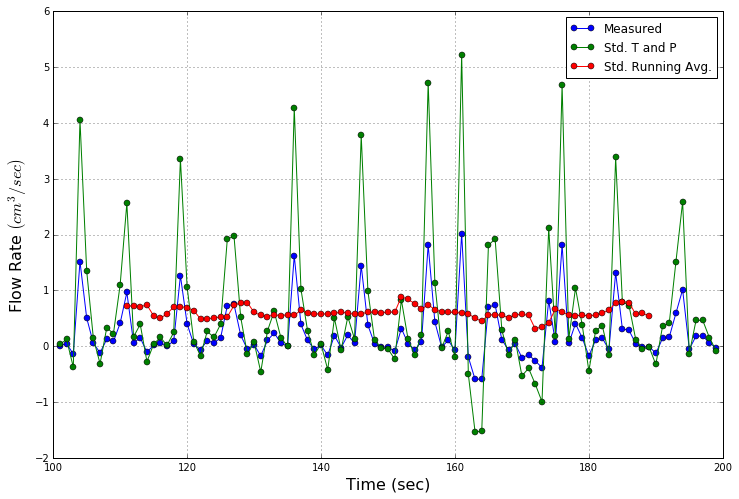

In [43]:
V1_dot =m1_dot/rho1_avg #volumetric flow rate into sample (m3/sec)
V1_dot_std = (P1_avg*V1_dot/(T_avg*rf.z_n2(T_avg, P1_avg)))*(Tstd*rf.z_n2(Tstd, Pstd)/Pstd)# [m3/sec at Standard Conditions]

V1_dot_std_win = runAvg(V1_dot_std, window)

fig_flow, ax = plt.subplots(1, figsize=(12,8))

meas, = ax.plot(time[1:],V1_dot*1e6, 'o-', label='Measured')
std, = ax.plot(time[1:],V1_dot_std*1e6, 'o-', label='Std. T and P')
win,  = ax.plot(time[1+trim:-trim],V1_dot_std_win*1e6, 'o-', label='Std. Running Avg.')

ax.set_ylabel(''r'Flow Rate $\left(cm^3/sec\right)$', fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=16)
ax.legend(handles=[meas, std, win])
ax.grid(True)

Calculate permeability

In [44]:
term1 = mu*L/A#[Pa-s-m/m2]
term2 = (2*P1_avg)/(P1_avg**2-Patm_pa**2)#[1/Pa]
term3 = V1_dot_std# rho1_avg/m1_dot#[m3/sec]
perm_all = term1*term2*term3; #[m2]
perm = np.mean(perm_all)
perm_dev = np.std(perm_all)
# perm_all_darcy = perm/(0.9869e-6); 

In [45]:
print(perm)
print(perm_dev)

1.6839364422e-15
3.6074261622e-15


Values calculated using runAvg

In [46]:
term1_avg = runAvg(mu*L/A, window)#[Pa-s-m/m2]
term2_avg = runAvg((2*P1_avg)/(P1_avg**2-Patm_pa**2), window)#[1/Pa]
term3_avg = V1_dot_std_win# rho1_avg/m1_dot#[m3/sec]
perm_avg = term1_avg*term2_avg*term3_avg; #[m2]
perm_avg_avg = np.mean(perm_avg)
perm_avg_dev = np.std(perm_avg)
# perm_all_darcy = perm/(0.9869e-6); 

In [47]:
print(perm_avg_avg)

1.69241974729e-15


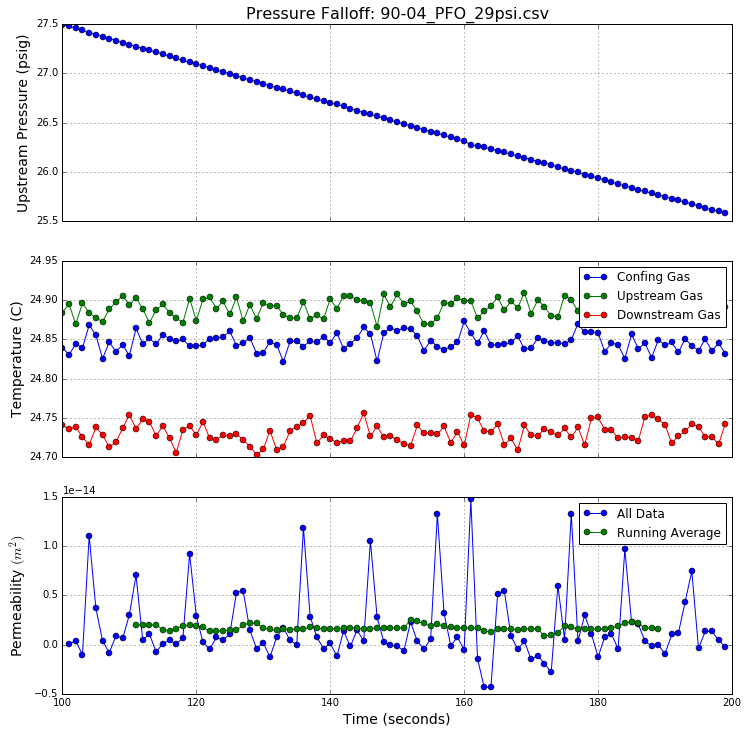

In [48]:
fig_results, ax = plt.subplots(3, sharex=True, figsize = (12,12))
fig_results_name = 'PFO_'+fname[:-3]+'pdf'

ax[0].plot(time, pdiff_psi, "o-")
ax[1].plot(time, T_conf, "o-")
ax[1].plot(time, T_us, "o-")
ax[1].plot(time, T_ds, "o-")

perm_all_plt, =ax[2].plot(time[1:], perm_all, "o-", label='All Data')
perm_win_plt, =ax[2].plot(time[1+trim:-trim], perm_avg, "o-", label='Running Average')
ax[2].legend(handles=[perm_all_plt, perm_win_plt])

lbl_temp = np.array(['Confing Gas', 'Upstream Gas', 'Downstream Gas']).astype(str)
ax[1].legend(lbl_temp, frameon=1, framealpha = 1, loc=1)

ax[2].set_xlabel('Time (seconds)', fontsize = 14)

ax[0].set_ylabel('Upstream Pressure (psig)', fontsize = 14)
ax[1].set_ylabel('Temperature (C)', fontsize = 14)
ax[2].set_ylabel('Permeability $(m^2)$', fontsize = 14)

ax[0].grid(True, which = 'major')
ax[1].grid(True, which = 'major')
ax[2].grid(True, which = 'major')

# perm_lbl =r'$k_m$ = {:.2E} $\pm$ {:.1E} $m^2$'.format(perm, 2*perm_dev)
# ax[2].text(2, 1.0e-15, s=perm_lbl, fontsize=15,bbox={'facecolor':'white', 'pad':10})

lbl = 'Pressure Falloff: '+fname
ax[0].set_title(lbl, fontsize=16)

# save to file
path = "/Users/Lampe/GrantNo456417/CurrentTesting/Permeability"
out_file = path + "/" + fig_results_name
fig_results.savefig(out_file)

#### Error Analysis

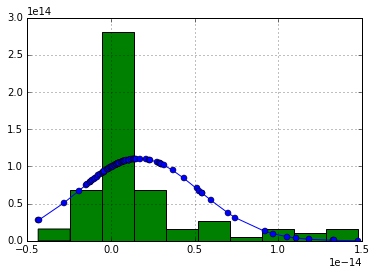

In [49]:
perm_all.sort()

k= np.asarray(perm_all).astype(np.float)
pmean = np.mean(k)
pstd = np.std(k)

pdf = stats.norm.pdf(k, pmean, pstd) # probability distribution function

plt.plot(k, pdf, 'o-') # including perm_all here is crucial
plt.hist(k, normed=True)
plt.grid(True)

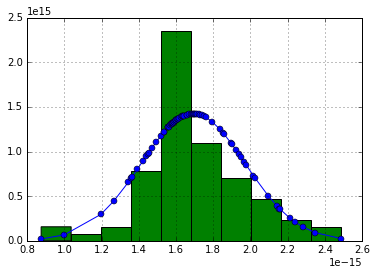

In [50]:
perm_avg.sort()

k= np.asarray(perm_avg).astype(np.float)
pmean = np.mean(k)
pstd = np.std(k)

pdf = stats.norm.pdf(k, pmean, pstd) # probability distribution function

plt.plot(k, pdf, 'o-') # including perm_all here is crucial
plt.hist(k, normed=True)
plt.grid(True)

Klinkenberg Effect

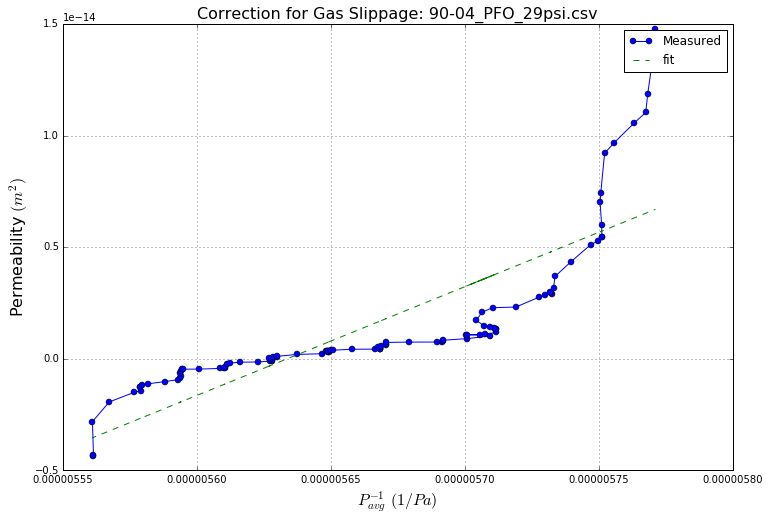

In [51]:
fig_klink, ax = plt.subplots(1, figsize=(12,8))
fig_klink_name = 'klink_'+fname[:-3]+'pdf'

x = 1/P_avg
y = perm_all
# fit to data
slope, inter = np.polyfit(x, y, 1)

perm_inf = inter
B = slope/inter

data, = ax.plot(x, y, 'o-', label='Measured')
fit, = ax.plot(x, slope*x + inter, '--', label='fit')

ax.set_ylabel(r'Permeability $(m^2)$', fontsize=16)
ax.set_xlabel(r'$P_{avg}^{-1}$ $(1/Pa)$', fontsize=16)
ax.legend(handles=[data, fit])

lbl = 'Correction for Gas Slippage: '+fname
ax.set_title(lbl,fontsize=16)
# ax.set_xlim(0,7e-6)

# perm_lbl =r'B = {:.2E} $Pa$ | Klink. Perm. = {:.1E} $m^2$'.format(B, perm_inf)
# ax.text(5.85e-6, 1.0e-15, s=perm_lbl, fontsize=15,bbox={'facecolor':'white', 'pad':10})

ax.grid(True)

# save to file
path = "/Users/Lampe/GrantNo456417/CurrentTesting/Permeability"
out_file = path + "/" + fig_klink_name
fig_klink.savefig(out_file)

In [52]:
print(perm_inf) #klinkenberg corrected perm [m2]
print(B) #klink B parameter [Pa]

-2.74336880227e-13
-177503.740184


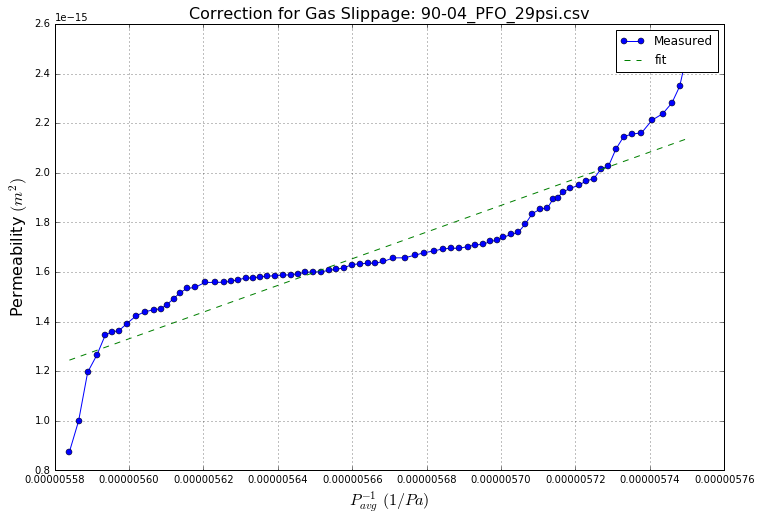

In [53]:
fig_klink_avg, ax = plt.subplots(1, figsize=(12,8))
fig_klink_name = 'klink_avg_'+fname[:-3]+'pdf'

x = 1/runAvg(P_avg,window)
y = perm_avg
# fit to data
slope, inter = np.polyfit(x, y, 1)

perm_inf = inter
B = slope/inter

data, = ax.plot(x, y, 'o-', label='Measured')
fit, = ax.plot(x, slope*x + inter, '--', label='fit')

ax.set_ylabel(r'Permeability $(m^2)$', fontsize=16)
ax.set_xlabel(r'$P_{avg}^{-1}$ $(1/Pa)$', fontsize=16)
ax.legend(handles=[data, fit])

lbl = 'Correction for Gas Slippage: '+fname
ax.set_title(lbl,fontsize=16)
# ax.set_xlim(0,7e-6)

# perm_lbl =r'B = {:.2E} $Pa$ | Klink. Perm. = {:.1E} $m^2$'.format(B, perm_inf)
# ax.text(5.85e-6, 1.0e-15, s=perm_lbl, fontsize=15,bbox={'facecolor':'white', 'pad':10})

ax.grid(True)

# save to file
path = "/Users/Lampe/GrantNo456417/CurrentTesting/Permeability"
out_file = path + "/" + fig_klink_name
fig_klink_avg.savefig(out_file)

In [40]:
print(perm_inf) #klinkenberg corrected perm [m2]
print(B) #klink B parameter [Pa]

-7.85618842774e-15
-301050.494029
